# Содержание
- [Введение](#intro)
- [Постановка задачи](#task_st)
- [Численный алгоритм](#num_algo)
- [Тестовые расчёты](#test_calcs)
- [Решение задачи](#sol)
  - [Теория](#theory)
  - [Практика](#practice)
- [Выводы](#conclusion)

# <a id="intro"></a> Введение

Уравнение теплопроводности является фундаментальным во многих областях чистой и прикладной математики. Это уравнение параболического типа. Оно используется для описания диффузии частиц в примеси, распростронения тепла в различных системах (например, в полимерах), моделирования опционов (финансовая математика), анализа изображений (машинное обучение). 

# <a id="task_st"></a> Постановка задачи

Получить численное решение **уравнения теплопроводности**, описывающего распространение температуры, используя разностные схемы расщепления.

Полученные результаты сравнить между собой, исследовать сходимость численного решения по сетке.

В работе будем рассматривать двумерное однородное уравнение теплопроводности с постоянным коэффициентом.\
Решение требуется получить в параллелепипеде $П = \{(x,y,t) \Big| 0 \leq x \leq 1,\ 0 \leq y \leq 1, 0 \leq t \leq 1 \}$.\
Граничные условия поставим первого рода (Дирихле), то есть зададим температуру на гранях $П$. Возьмём одинаковые значения для всех моментов времени. 

- При $x = 0$ температура будет $0$
- При $x = 1$ температура будет $1$
- При $y = 0$ температура будет $2$
- При $y = 1$ температура будет $3$

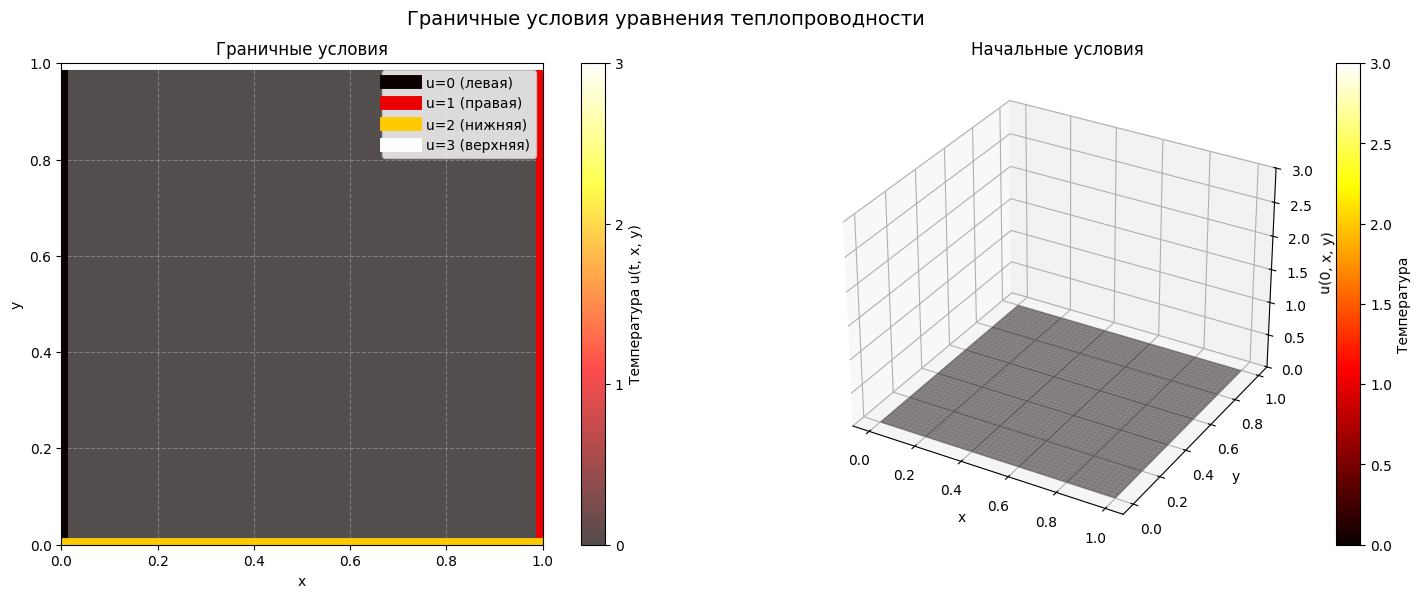

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Параметры области
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)

# Начальное условие u(0, x, y) = 0
U_initial = np.zeros_like(X)

# Граничные условия
U_left = np.zeros_like(y)       # u(t, 0, y) = 0
U_right = np.ones_like(y)      # u(t, 1, y) = 1
U_bottom = 2 * np.ones_like(x) # u(t, x, 0) = 2
U_top = 3 * np.ones_like(x)    # u(t, x, 1) = 3

# Создаём фигуру с двумя подграфиками
fig = plt.figure(figsize=(16, 6))

# --- 2D график ---
ax1 = fig.add_subplot(121)
im = ax1.imshow(U_initial, extent=[0, 1, 0, 1], origin='lower',
               cmap='hot', vmin=0, vmax=3, alpha=0.7)
cbar = fig.colorbar(im, ax=ax1, label='Температура u(t, x, y)')
cbar.set_ticks([0, 1, 2, 3])

# Граничные условия с цветами из cmap 'hot'
ax1.plot([0, 0], [0, 1], color=plt.cm.hot(0/3), linewidth=10, label='u=0 (левая)')
ax1.plot([1, 1], [0, 1], color=plt.cm.hot(1/3), linewidth=10, label='u=1 (правая)')
ax1.plot([0, 1], [0, 0], color=plt.cm.hot(2/3), linewidth=10, label='u=2 (нижняя)')
ax1.plot([0, 1], [1, 1], color=plt.cm.hot(3/3), linewidth=10, label='u=3 (верхняя)')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Граничные условия')
ax1.legend(loc='upper right')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- 3D график ---
ax2 = fig.add_subplot(122, projection='3d')

# Основная поверхность (начальное условие)
surf = ax2.plot_surface(X, Y, U_initial, cmap='hot', vmin=0, vmax=3, alpha=0.5)

# Граничные условия в 3D (как "стенки")
# Левая граница (x=0)
ax2.plot_surface(np.zeros_like(X), Y, U_initial, color=plt.cm.hot(0/3), alpha=0.8)
# Правая граница (x=1)
ax2.plot_surface(np.ones_like(X), Y, U_initial, color=plt.cm.hot(1/3), alpha=0.8)
# Нижняя граница (y=0)
ax2.plot_surface(X, np.zeros_like(Y), U_initial+2, color=plt.cm.hot(2/3), alpha=0.8)
# Верхняя граница (y=1)
ax2.plot_surface(X, np.ones_like(Y), U_initial+3, color=plt.cm.hot(3/3), alpha=0.8)

# Настройки 3D графика
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(0, x, y)')
ax2.set_title('Начальные условия')
ax2.set_zlim(0, 3)

# Общая цветовая шкала
sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=3))
sm.set_array([])
fig.colorbar(sm, ax=ax2, label='Температура')

plt.suptitle('Граничные условия уравнения теплопроводности', fontsize=14)
plt.tight_layout()
plt.show()

# <a id="num_algo"></a> Численный алгоритм

Будем использовать 4 схемы.

**а)** Схема Яненко
$$
\left\{
\begin{aligned}
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} &= \Lambda_1\tilde{u}_{ml}\\
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} &= \Lambda_2u^{n+1}_{ml}
\end{aligned}
\right.\\
$$
$$ 
\Lambda_1\tilde{u}_{ml} = \frac{\tilde{u}_{m-1,l} - 2\tilde{u}_{m,l}+\tilde{u}_{m+1,l}}{h_{x}^2} 
$$
$$
\Lambda_2u_{ml}^{n+1} = \frac{u^{n+1}_{m,l-1} - 2u^{n+1}_{m,l}+u^{n+1}_{m,l+1}}{h_{y}^2} 
$$
**б)** Схема Кранка-Николсона
$$
\left\{
\begin{aligned}
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} &= \Lambda_1\Big[\frac{\tilde{u}_{ml} + u^{n}_{ml}}{2}\Big],\\
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} &= \Lambda_2\Big[\frac{u^{n+1}_{ml} + \tilde{u}_{ml}}{2}\Big]
\end{aligned}
\right.\\
$$
Здесь положено $\xi = 1/2$.\
**в)** Схема Писмена-Речфорда
$$
\left\{
\begin{aligned}
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} &= \frac{1}{2}(\Lambda_1\tilde{u}_{ml} + \Lambda_2u^{n}_{ml}),\\
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} &= \frac{1}{2}(\Lambda_1\tilde{u}_{ml} + \Lambda_2u^{n+1}_{ml})
\end{aligned}
\right.\\
$$
**г)** Явная схема переменных направлений
$$
\left\{
\begin{aligned}
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} &= \Lambda_1u^{n}_{ml}\\
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} &= \Lambda_2\tilde{u}_{ml}
\end{aligned}
\right.\\
$$

$$ 
\Lambda_1u^{n}_{ml} = \frac{u^{n}_{m-1,l} - 2u^{n}_{m,l}+u^{n}_{m+1,l}}{h_{x}^2} 
$$

$$
\Lambda_2\tilde{u}_{ml} = \frac{\tilde{u}_{m,l-1} - 2\tilde{u}_{m,l}+\tilde{u}_{m,l+1}}{h_{y}^2} 
$$

В каждой схеме шаг по времени разбивается на два "полушага".

Сначала вычисляется промежуточное, не имеющее физ. смысла решение $\tilde{u}_{ml}$ (первый полушаг).\
Затем с его помощью рассчитывается решение на новом временном слое $u^{n+1}_{ml}$ (второй полушаг).

Схемы различаются способом совершения первого и второго полушагов.
- Схема а) неявная, при вычислении $\tilde{u}_{ml}$ получается трёхдиагональная система линейных алгебраических уравнений. Затем она решается методом прогонки (трёхдиагональной). Далее аналогично по неявной схеме вычисляется $u^{n+1}_{ml}$. Тепло как бы сначала распространяется по оси $x$, а потом по оси $y$.
- Схема б) тоже неявная, и там тоже получаются две трёхдиагональные системы уравнений, однако матричные элементы другие. 
Общий вид схемы Кранка-Никлсона:
$$
\left\{
\begin{aligned}
\frac{u^{n+1/2}_{ml} - u^{n}_{ml}}{\tau} &= \Lambda_1[\xi u^{n+1/2}_{ml} + (1-\xi)u^{n}_{ml}],\\
\frac{u^{n+1/2}_{ml} - u^{n+1/2}_{ml}}{\tau} &= \Lambda_2[\xi u^{n+1}_{ml} + (1-\xi)u^{n+1/2}_{ml}]
\end{aligned}
\right.\\
$$
При $\xi = 1$ получается схема а), при $\xi = 0$ получается схема г).
- Схема в) тоже неявная, но здесь аппроксимации производных по $x$ и по $y$ перемешаны между собой. В остальном то же самое - две системы, рашемые методом прогонки.
- В схеме г) сразу же можно рассчитать $\tilde{u}_{ml}$ по готовой формуле, затем и $u^{n+1}_{ml}$. Оба полушага явные.

# <a id="test_calcs"></a> Тестовые расчёты

Верифицируем схемы, применив их для решения уравнения, для которого известно точное аналитическое решение.

Рассмотрим функцию $u(t,x,y) = e^{-2\pi^2t}\sin(\pi x)\sin(\pi y)$.

Убедимся, что она действительно является решением задачи Дирихле
$$
\left\{
\begin{aligned}
\frac{\partial{u}}{\partial{t}} &= \frac{\partial^2{u}}{\partial{x}^2} + \frac{\partial^2{u}}{\partial{y}^2},\ 0 \leq x \leq 1,\ 0 \leq y \leq 1,\ 0 \leq t \leq 1\\
u(0,x,y) &= \sin(\pi x)\sin(\pi y)\\
u(t, 0, y) &= u(t, 1, y) = 0\\
u(t, x, 0) &= u(t, x, 1) = 0
\end{aligned}
\right.\\
$$

...

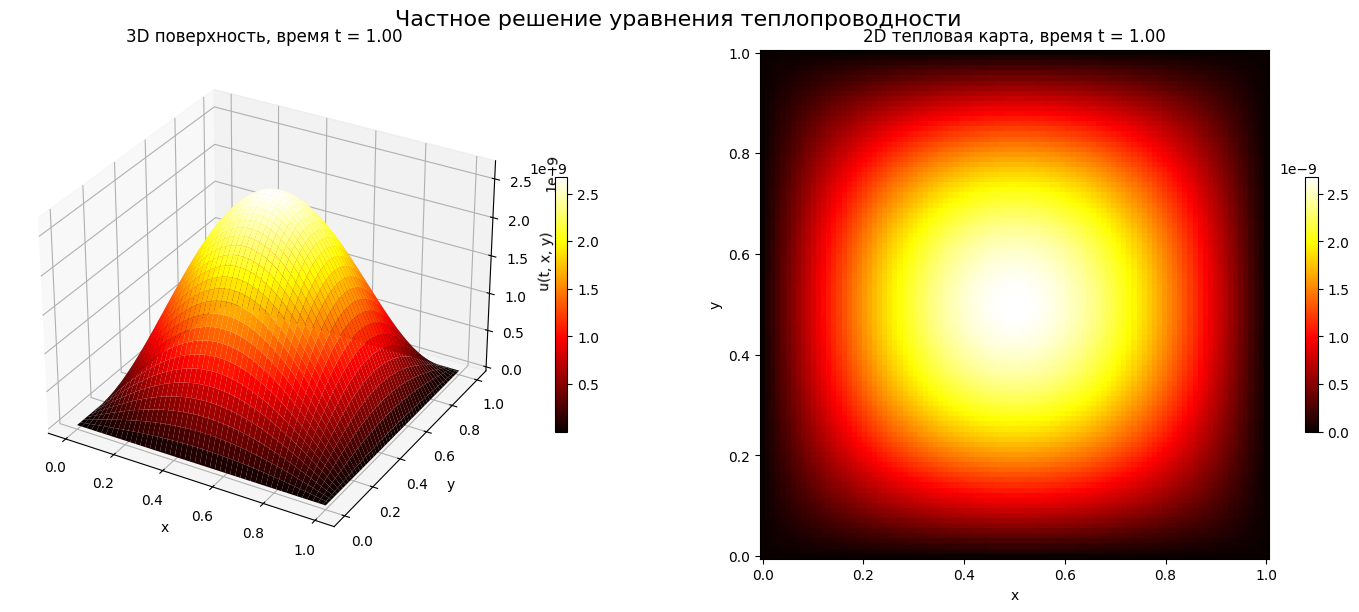

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Параметры
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
t_values = [1]

# Функция решения
def u(t, x, y):
    return np.exp(-2 * np.pi**2 * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Визуализация
fig = plt.figure(figsize=(15, 6))  # Уменьшил высоту, так как теперь только одна строка

for i, t in enumerate(t_values):
    # 3D график
    ax_3d = fig.add_subplot(1, 2, 1, projection='3d')
    Z = u(t, X, Y)
    surf = ax_3d.plot_surface(X, Y, Z, cmap='hot')
    ax_3d.set_title(f'3D поверхность, время t = {t:.2f}')
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('y')
    ax_3d.set_zlabel('u(t, x, y)')
    fig.colorbar(surf, ax=ax_3d, shrink=0.5)
    
    # 2D цветовая карта
    ax_2d = fig.add_subplot(1, 2, 2)
    heatmap = ax_2d.pcolormesh(X, Y, Z, cmap='hot')
    ax_2d.set_title(f'2D тепловая карта, время t = {t:.2f}')
    ax_2d.set_xlabel('x')
    ax_2d.set_ylabel('y')
    ax_2d.set_aspect('equal')
    fig.colorbar(heatmap, ax=ax_2d, shrink=0.5)

plt.suptitle('Частное решение уравнения теплопроводности', fontsize=16)
plt.tight_layout()
plt.show()


## Схема а) Яненко

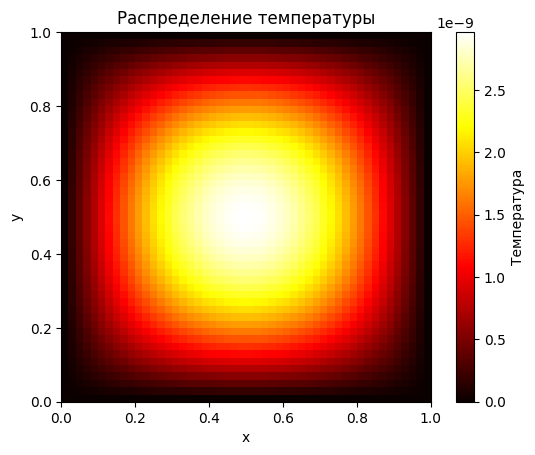

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Параметры сетки
Nx, Ny = 50, 50  # Количество узлов по x и y
hx, hy = 1.0 / (Nx - 1), 1.0 / (Ny - 1)
tau = 0.001  # Шаг по времени
T = 1  # Общее время

# Инициализация
u = np.zeros((Nx, Ny))
for m in range(1, Nx - 1):
    x = hx * m
    for l in range(1, Ny - 1):
        y = hy * l
        u[m,l] = np.sin(np.pi * x) * np.sin(np.pi * y)

# Граничные условия
u[:, 0] = 0  # y = 0
u[:, -1] = 0  # y = 1
u[0, :] = 0  # x = 0
u[-1, :] = 0  # x = 1

# Коэффициенты для разностных операторов
alpha = tau / hx**2
beta = tau / hy**2

# Первый полушаг (неявный по x)
def step_x(u, alpha, Nx, Ny):
    # Строим матрицу для неявной схемы по x
    main_diag = np.ones(Nx - 2) * (1 + 2 * alpha)
    off_diag = np.ones(Nx - 3) * (-alpha)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    # Решаем для каждого y
    for l in range(1, Ny - 1):
        b = u[1:-1, l].copy()
        # Учет граничных условий
        b[0] += alpha * u[0, l]
        b[-1] += alpha * u[-1, l]
        u[1:-1, l] = spsolve(A, b)
    return u

# Второй полушаг (неявный по y)
def step_y(u, beta, Nx, Ny):
    # Строим матрицу для неявной схемы по y
    main_diag = np.ones(Ny - 2) * (1 + 2 * beta)
    off_diag = np.ones(Ny - 3) * (-beta)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    # Решаем для каждого x
    for m in range(1, Nx - 1):
        b = u[m, 1:-1].copy()
        # Учет граничных условий
        b[0] += beta * u[m, 0]
        b[-1] += beta * u[m, -1]
        u[m, 1:-1] = spsolve(A, b)
    return u

# Временной цикл
for n in range(int(T / tau)):
    u = step_x(u, alpha, Nx, Ny)  # Шаг по x
    u = step_y(u, beta, Nx, Ny)   # Шаг по y

# Визуализация
plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label='Температура')
plt.title('Распределение температуры')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Схема б) Кранка-Николсона

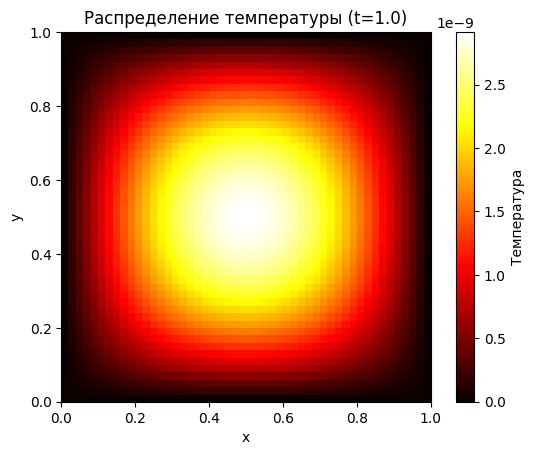

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve

# Параметры сетки
Nx, Ny = 50, 50
hx, hy = 1/(Nx-1), 1/(Ny-1)
tau = 0.0001
T = 1.0
Nt = int(T/tau)

# Инициализация с учетом граничных условий
u = np.zeros((Nx, Ny))
for m in range(1, Nx - 1):
    x = hx * m
    for l in range(1, Ny - 1):
        y = hy * l
        u[m,l] = np.sin(np.pi * x) * np.sin(np.pi * y)

u[:, 0] = 0.0   # y=0
u[:, -1] = 0.0  # y=1
u[0, :] = 0.0   # x=0
u[-1, :] = 0.0  # x=1

def step_x(u_prev, hx, hy, tau):
    """Полушаг по x с обновлением только внутренних точек"""
    u_next = u_prev.copy()  # Сохраняем границы
    
    # Строим матрицу
    alpha = tau/hx**2
    main_diag = (1 + alpha) * np.ones(Nx)
    off_diag = (-alpha/2) * np.ones(Nx-1)
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')
    
    for l in range(1, Ny-1):
        # Правая часть с перекрестными производными
        b = u_prev[:, l].copy()
        b[1:-1] += (tau/(2*hy**2)) * (
            u_prev[1:-1, l+1] - 2*u_prev[1:-1, l] + u_prev[1:-1, l-1]
        )
        
        # Решаем только для внутренних точек
        u_next[1:-1, l] = spsolve(A, b)[1:-1]
    
    return u_next

def step_y(u_prev, hx, hy, tau):
    """Полушаг по y с обновлением только внутренних точек"""
    u_next = u_prev.copy()  # Сохраняем границы
    
    # Строим матрицу
    beta = tau/hy**2
    main_diag = (1 + beta) * np.ones(Ny)
    off_diag = (-beta/2) * np.ones(Ny-1)
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')
    
    for m in range(1, Nx-1):
        # Правая часть с перекрестными производными
        b = u_prev[m, :].copy()
        b[1:-1] += (tau/(2*hx**2)) * (
            u_prev[m+1, 1:-1] - 2*u_prev[m, 1:-1] + u_prev[m-1, 1:-1]
        )
        
        # Решаем только для внутренних точек
        u_next[m, 1:-1] = spsolve(A, b)[1:-1]
    
    return u_next

# Временной цикл
for k in range(Nt):
    u = step_x(u, hx, hy, tau)
    u = step_y(u, hx, hy, tau)

# Визуализация
plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label='Температура')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Распределение температуры (t={T})')
plt.show()

## Схема в) Писмена-Речфорда

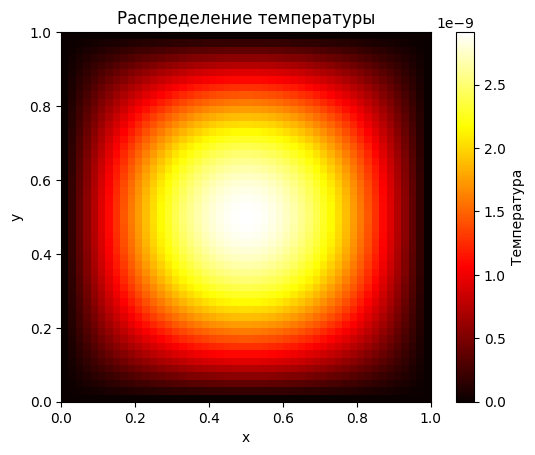

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Параметры сетки
Nx, Ny = 50, 50
hx, hy = 1/(Nx-1), 1/(Ny-1)
tau = 0.0001
T = 1  # Увеличим время для установления стационарного режима
Nt = int(T/tau)

# Инициализация с учетом граничных условий
u = np.zeros((Nx, Ny))
for m in range(1, Nx - 1):
    x = hx * m
    for l in range(1, Ny - 1):
        y = hy * l
        u[m,l] = np.sin(np.pi * x) * np.sin(np.pi * y)
u[:, 0] = 0  # y=0
u[:, -1] = 0  # y=1
u[0, :] = 0   # x=0
u[-1, :] = 0  # x=1

def step_x(u_prev, hx, hy, tau):
    Nx, Ny = u_prev.shape
    u_next = u_prev.copy()  # Сохраняем граничные условия
    
    main_diag = (1 + tau/hx**2) * np.ones(Nx)
    off_diag = (-tau/(2*hx**2)) * np.ones(Nx-1)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    for l in range(1, Ny-1):
        b = u_prev[:, l] + (tau/(2*hy**2))*(u_prev[:, l+1] - 2*u_prev[:, l] + u_prev[:, l-1])
        # Граничные x=0 и x=1 уже учтены в u_prev
        u_next[1:-1, l] = spsolve(A, b)[1:-1]  # Обновляем только внутренние точки
    
    return u_next

def step_y(u_prev, hx, hy, tau):
    Nx, Ny = u_prev.shape
    u_next = u_prev.copy()  # Сохраняем граничные условия
    
    main_diag = (1 + tau/hy**2) * np.ones(Ny)
    off_diag = (-tau/(2*hy**2)) * np.ones(Ny-1)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    for m in range(1, Nx-1):
        b = u_prev[m, :] + (tau/(2*hx**2))*(u_prev[m+1, :] - 2*u_prev[m, :] + u_prev[m-1, :])
        # Граничные y=0 и y=1 уже учтены в u_prev
        u_next[m, 1:-1] = spsolve(A, b)[1:-1]  # Обновляем только внутренние точки
    
    return u_next

# Временной цикл
for k in range(Nt):
    u = step_x(u, hx, hy, tau)
    u = step_y(u, hx, hy, tau)
    
    # Визуализация процесса (опционально)
    #if k % 1000 == 0:
    #    print(f"Шаг {k}/{Nt}, T={k*tau:.3f}, u(0.5,1)={u[Nx//2, -1]:.3f}")

# Проверка граничных условий
# print("\nПроверка граничных условий:")
# print(f"u(x,0) = {u[Nx//2, 0]:.3f} (должно быть 2)")
# print(f"u(x,1) = {u[Nx//2, -1]:.3f} (должно быть 3)")
# print(f"u(0,y) = {u[0, Ny//2]:.3f} (должно быть 0)")
# print(f"u(1,y) = {u[-1, Ny//2]:.3f} (должно быть 1)")

# Визуализация
plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label='Температура')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Распределение температуры')
plt.show()

## Схема г) явная

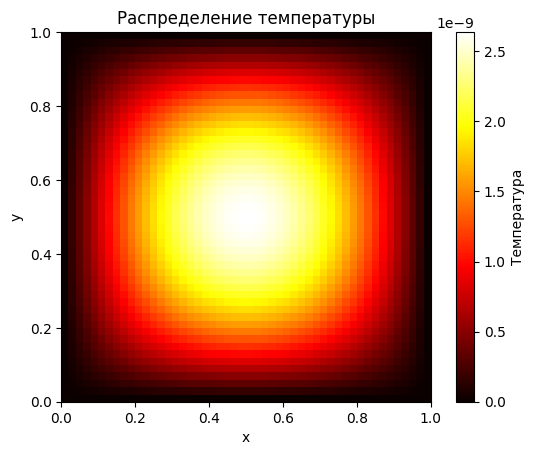

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры сетки
Nx = 50  # Число узлов по x
Ny = 50  # Число узлов по y
hx = 1.0 / (Nx - 1)
hy = 1.0 / (Ny - 1)
tau = 0.5 * min(hx**2, hy**2)  # Условие устойчивости
T = 1  # Конечное время
Nt = int(T / tau)  # Число шагов по времени

# Инициализация сетки
u = np.zeros((Nx, Ny))
for m in range(1, Nx - 1):
    x = hx * m
    for l in range(1, Ny - 1):
        y = hy * l
        u[m,l] = np.sin(np.pi * x) * np.sin(np.pi * y)

# Граничные условия
u[:, 0] = 0  # y = 0
u[:, -1] = 0  # y = 1
u[0, :] = 0  # x = 0
u[-1, :] = 0  # x = 1

# Основной цикл по времени
for n in range(Nt):
    # Промежуточный шаг (по x)
    u_tilde = np.zeros((Nx, Ny))
    for m in range(1, Nx-1):
        for l in range(1, Ny-1):
            u_tilde[m, l] = u[m, l] + (tau / hx**2) * (u[m-1, l] - 2*u[m, l] + u[m+1, l])
    
    # Граничные условия для u_tilde
    u_tilde[0, :] = 0  # x = 0
    u_tilde[-1, :] = 0  # x = 1
    u_tilde[:, 0] = 0   # y = 0
    u_tilde[:, -1] = 0  # y = 1
    
    # Шаг по y
    for m in range(1, Nx-1):
        for l in range(1, Ny-1):
            u[m, l] = u_tilde[m, l] + (tau / hy**2) * (u_tilde[m, l-1] - 2*u_tilde[m, l] + u_tilde[m, l+1])
    
    # Обновляем граничные условия для u
    u[0, :] = 0  # x = 0
    u[-1, :] = 0  # x = 1
    u[:, 0] = 0   # y = 0
    u[:, -1] = 0  # y = 1

# Визуализация через heatmap
plt.imshow(u.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(label='Температура')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Распределение температуры')
plt.show()

Видим, что все 4 схемы воспроизводят аналитическое решение.

# <a id="sol"></a> Решение задачи

## Pасчёты по разностным схемам

$$
\frac{\partial{u}}{\partial{t}} = \frac{\partial^2{u}}{\partial{x}^2} + \frac{\partial^2{u}}{\partial{y}^2},\ 0 \leq x \leq 1,\ 0 \leq y \leq 1,\ 0 \leq t \leq 1
$$

$$
u(0, x, y) = 0,\quad t = 0,\ 0 \leq x \leq 1,\ 0 \leq y \leq 1 \\
u(t, 0, y) = 0,\quad 0 \leq t \leq 1,\ x = 0,\ 0 \leq y \leq 1 \\ 
u(t, 1, y) = 1,\quad 0 \leq t \leq 1,\ x = 1,\ 0 \leq y \leq 1 \\ 

u(t, x, 0) = 2,\quad 0 \leq t \leq 1, 0 \leq x \leq 1,\ y = 0 \\
u(t, x, 1) = 3,\quad 0 \leq t \leq 1, 0 \leq x \leq 1,\ y = 1 
$$

Непротиворечивая задача:
$$
\frac{\partial{u}}{\partial{t}} = \frac{\partial^2{u}}{\partial{x}^2} + \frac{\partial^2{u}}{\partial{y}^2},\ 0 \leq x \leq 1,\ 0 \leq y \leq 1,\ 0 \leq t \leq 1
$$

$$
u(0, x, y) = 0,\quad t = 0,\ 0 \leq x \leq 1,\ 0 \leq y \leq 1 \\
u(t, 0, y) = 0,\quad 0 < t \le 1,\ x = 0,\ 0 \le y \leq 1 \\ 
u(t, 1, y) = 1,\quad 0 < t \leq 1,\ x = 1,\ 0 \le y \leq 1 \\ 

u(t, x, 0) = 2,\quad 0 < t \leq 1, 0 < x < 1,\ y = 0 \\
u(t, x, 1) = 3,\quad 0 < t \leq 1, 0 < x < 1,\ y = 1
$$

Введём для разностной аппроксимации расчётную сетку
$$
t = n\tau;\ n = 0,1,...,N;\ \tau = \frac{1}{N}\\
x_m = mh_x;\ m = 0,1,...,M;\ h_x = \frac{1}{M}\\
y_l = lh_y;\ l = 0,1,...,L;\ h_y = \frac{1}{L}
$$

Граничные условия:
$$
u^{0}_{ml} = 0;\\
u^{n}_{0,l} = 0;\ u^{n}_{M,l} = 1\\
u^{n}_{l,0} = 2;\ u^{n}_{m,L} = 3
$$
Здесь $ u^{n}_{lm}$ - решение разностной задачи на временном слое $n$ в точке $x = l h_x$, $ y = m h_y $

### а) Схема Яненко

$$
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} = \Lambda_1\tilde{u}_{ml}
$$ 

$$ 
\Lambda_1\tilde{u}_{ml} = \frac{\tilde{u}_{m-1,l} - 2\tilde{u}_{m,l}+\tilde{u}_{m+1,l}}{h_{x}^2} 
$$

$$
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} = \Lambda_2u^{n+1}_{ml}
$$
$$
\Lambda_2u_{ml}^{n+1} = \frac{u^{n+1}_{m,l-1} - 2u^{n+1}_{m,l}+u^{n+1}_{m,l+1}}{h_{y}^2} 
$$

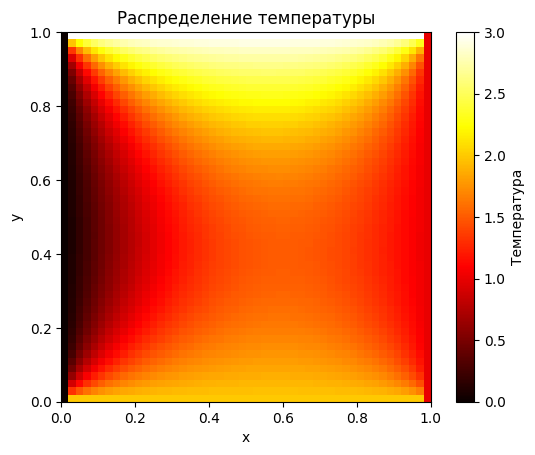

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Параметры сетки
Nx, Ny = 50, 50  # Количество узлов по x и y
hx, hy = 1.0 / (Nx - 1), 1.0 / (Ny - 1)
tau = 0.001  # Шаг по времени
T = 1  # Общее время

# Инициализация
u = np.zeros((Nx, Ny))

# Граничные условия
u[:, 0] = 2  # y = 0
u[:, -1] = 3  # y = 1
u[0, :] = 0  # x = 0
u[-1, :] = 1  # x = 1

# Коэффициенты для разностных операторов
alpha = tau / hx**2
beta = tau / hy**2

# Первый полушаг (неявный по x)
def step_x(u, alpha, Nx, Ny):
    # Строим матрицу для неявной схемы по x
    main_diag = np.ones(Nx - 2) * (1 + 2 * alpha)
    off_diag = np.ones(Nx - 3) * (-alpha)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    # Решаем для каждого y
    for l in range(1, Ny - 1):
        b = u[1:-1, l].copy()
        # Учет граничных условий
        b[0] += alpha * u[0, l]
        b[-1] += alpha * u[-1, l]
        u[1:-1, l] = spsolve(A, b)
    return u

# Второй полушаг (неявный по y)
def step_y(u, beta, Nx, Ny):
    # Строим матрицу для неявной схемы по y
    main_diag = np.ones(Ny - 2) * (1 + 2 * beta)
    off_diag = np.ones(Ny - 3) * (-beta)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    # Решаем для каждого x
    for m in range(1, Nx - 1):
        b = u[m, 1:-1].copy()
        # Учет граничных условий
        b[0] += beta * u[m, 0]
        b[-1] += beta * u[m, -1]
        u[m, 1:-1] = spsolve(A, b)
    return u

# Временной цикл
for n in range(int(T / tau)):
    u = step_x(u, alpha, Nx, Ny)  # Шаг по x
    u = step_y(u, beta, Nx, Ny)   # Шаг по y

# Визуализация
plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label='Температура')
plt.title('Распределение температуры')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### б) Схема Кранка-Николсона

$$
\left\{
\begin{aligned}
\frac{u^{n+1/2}_{ml} - u^{n}_{ml}}{\tau} &= \Lambda_1[\frac{u^{n+1/2}_{ml} + u^{n}_{ml}}{2}],\\
\frac{u^{n+1}_{ml} - u^{n+1/2}_{ml}}{\tau} &= \Lambda_2[\frac{u^{n+1}_{ml} + u^{n+1/2}_{ml}}{2}]
\end{aligned}
\right.\\
$$
Здесь $\xi = 1/2$

При $\xi = 1$ получили бы предыдущую схему.

$$ 
\Lambda_1\tilde{u}_{ml} = \frac{\tilde{u}_{m-1,l} - 2\tilde{u}_{m,l}+\tilde{u}_{m+1,l}}{h_{x}^2} 
$$
$$
\Lambda_2\tilde{u}_{ml} = \frac{\tilde{u}_{m,l-1} - 2\tilde{u}_{m,l}+\tilde{u}_{m,l+1}}{h_{y}^2} 
$$

In [8]:
def thomas_algorithm(A, f):
  ### Прогоночные коэффиценты
  n = len(f)
  # a
  a = [0]
  [ a.append(A[row][row-1]) for row in range(1, n)]
  # b
  b = [A[row][row] for row in range(0, n)]
  # c
  c = [A[row][row+1] for row in range(0, n-1)]
  c.append(0)
  
  E_0 = -c[0]/b[0]
  F_0 = f[0]*b[0]
  
  E = np.array( [0.]*n )
  F = np.array( [0.]*n )
  E[0] = E_0
  F[0] = F_0
  
  for k in range(0, n):
    E[k] = -c[k]/(a[k]*E[k-1]+b[k])
  
  for k in range(0, n):
    F[k] = (f[k] - a[k]*F[k-1])/(a[k]*E[k-1]+b[k])
  
  # Расчёт ответа
  y = np.array( [0.]*n )
  y[n-1] = F[n-1]
  for k in range(n-2, -1 ,-1):
    y[k] = F[k] + E[k]*y[k+1]  
  
  return y

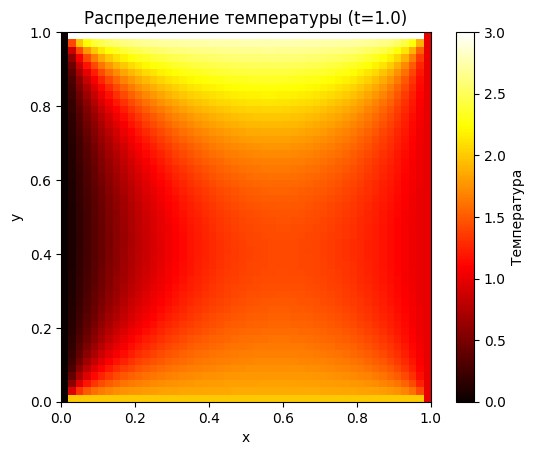

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve

# Параметры сетки
Nx, Ny = 50, 50
hx, hy = 1/(Nx-1), 1/(Ny-1)
tau = 0.0001
T = 1.0
Nt = int(T/tau)

# Инициализация с учетом граничных условий
u = np.zeros((Nx, Ny))
u[:, 0] = 2.0   # y=0
u[:, -1] = 3.0  # y=1
u[0, :] = 0.0   # x=0
u[-1, :] = 1.0  # x=1

def step_x(u_prev, hx, hy, tau):
    """Полушаг по x с обновлением только внутренних точек"""
    u_next = u_prev.copy()  # Сохраняем границы
    
    # Строим матрицу
    alpha = tau/hx**2
    main_diag = (1 + alpha) * np.ones(Nx)
    off_diag = (-alpha/2) * np.ones(Nx-1)
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')
    
    for l in range(1, Ny-1):
        # Правая часть с перекрестными производными
        b = u_prev[:, l].copy()
        b[1:-1] += (tau/(2*hy**2)) * (
            u_prev[1:-1, l+1] - 2*u_prev[1:-1, l] + u_prev[1:-1, l-1]
        )
        
        # Решаем только для внутренних точек
        u_next[1:-1, l] = spsolve(A, b)[1:-1]
    
    return u_next

def step_y(u_prev, hx, hy, tau):
    """Полушаг по y с обновлением только внутренних точек"""
    u_next = u_prev.copy()  # Сохраняем границы
    
    # Строим матрицу
    beta = tau/hy**2
    main_diag = (1 + beta) * np.ones(Ny)
    off_diag = (-beta/2) * np.ones(Ny-1)
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')
    
    for m in range(1, Nx-1):
        # Правая часть с перекрестными производными
        b = u_prev[m, :].copy()
        b[1:-1] += (tau/(2*hx**2)) * (
            u_prev[m+1, 1:-1] - 2*u_prev[m, 1:-1] + u_prev[m-1, 1:-1]
        )
        
        # Решаем только для внутренних точек
        u_next[m, 1:-1] = spsolve(A, b)[1:-1]
    
    return u_next

# Временной цикл
for k in range(Nt):
    u = step_x(u, hx, hy, tau)
    u = step_y(u, hx, hy, tau)
    
    # Контроль граничных условий
    # if k % 1000 == 0:
    #     print(f"Шаг {k}/{Nt}, u(0.5,1)={u[Nx//2, -1]:.3f} (должно быть 3)")

# Проверка граничных условий
# print("\nПроверка границ:")
# print(f"u(x,0) = {u[Nx//2, 0]:.3f} (должно быть 2)")
# print(f"u(x,1) = {u[Nx//2, -1]:.3f} (должно быть 3)")
# print(f"u(0,y) = {u[0, Ny//2]:.3f} (должно быть 0)")
# print(f"u(1,y) = {u[-1, Ny//2]:.3f} (должно быть 1)")

# Визуализация
plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label='Температура')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Распределение температуры (t={T})')
plt.show()

### в) Cхема Писмена-Речфорда

$$
\left\{
\begin{aligned}
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} &= \frac{1}{2}(\Lambda_1\tilde{u}_{ml} + \Lambda_2u^{n}_{ml}),\\
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} &= \frac{1}{2}(\Lambda_1\tilde{u}_{ml} + \Lambda_2u^{n+1}_{ml})
\end{aligned}
\right.\\
$$

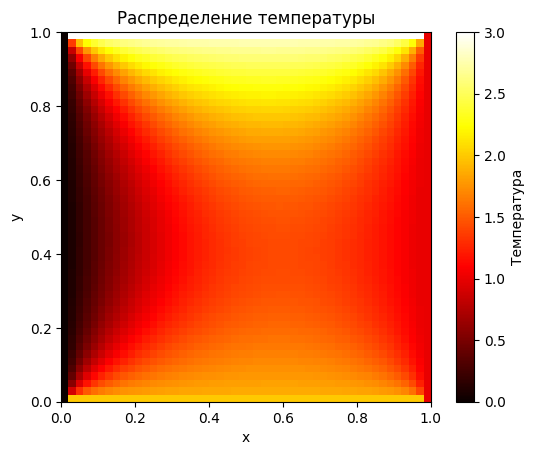

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Параметры сетки
Nx, Ny = 50, 50
hx, hy = 1/(Nx-1), 1/(Ny-1)
tau = 0.0001
T = 1  # Увеличим время для установления стационарного режима
Nt = int(T/tau)

# Инициализация с учетом граничных условий
u = np.zeros((Nx, Ny))
u[:, 0] = 2   # y=0
u[:, -1] = 3  # y=1
u[0, :] = 0   # x=0
u[-1, :] = 1  # x=1

def step_x(u_prev, hx, hy, tau):
    Nx, Ny = u_prev.shape
    u_next = u_prev.copy()  # Сохраняем граничные условия
    
    main_diag = (1 + tau/hx**2) * np.ones(Nx)
    off_diag = (-tau/(2*hx**2)) * np.ones(Nx-1)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    for l in range(1, Ny-1):
        b = u_prev[:, l] + (tau/(2*hy**2))*(u_prev[:, l+1] - 2*u_prev[:, l] + u_prev[:, l-1])
        # Граничные x=0 и x=1 уже учтены в u_prev
        u_next[1:-1, l] = spsolve(A, b)[1:-1]  # Обновляем только внутренние точки
    
    return u_next

def step_y(u_prev, hx, hy, tau):
    Nx, Ny = u_prev.shape
    u_next = u_prev.copy()  # Сохраняем граничные условия
    
    main_diag = (1 + tau/hy**2) * np.ones(Ny)
    off_diag = (-tau/(2*hy**2)) * np.ones(Ny-1)
    A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
    
    for m in range(1, Nx-1):
        b = u_prev[m, :] + (tau/(2*hx**2))*(u_prev[m+1, :] - 2*u_prev[m, :] + u_prev[m-1, :])
        # Граничные y=0 и y=1 уже учтены в u_prev
        u_next[m, 1:-1] = spsolve(A, b)[1:-1]  # Обновляем только внутренние точки
    
    return u_next

# Временной цикл
for k in range(Nt):
    u = step_x(u, hx, hy, tau)
    u = step_y(u, hx, hy, tau)

# Визуализация
plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label='Температура')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Распределение температуры')
plt.show()

### г) Явная схема

$$
\frac{\tilde{u}_{ml} - u^{n}_{ml}}{\tau} = \Lambda_1u^{n}_{ml}
$$ 

$$ 
\Lambda_1u^{n}_{ml} = \frac{u^{n}_{m-1,l} - 2u^{n}_{m,l}+u^{n}_{m+1,l}}{h_{x}^2} 
$$

$$
\frac{u^{n+1}_{ml} - \tilde{u}_{ml}}{\tau} = \Lambda_2\tilde{u}_{ml}
$$
$$
\Lambda_2\tilde{u}_{ml} = \frac{\tilde{u}_{m,l-1} - 2\tilde{u}_{m,l}+\tilde{u}_{m,l+1}}{h_{y}^2} 
$$

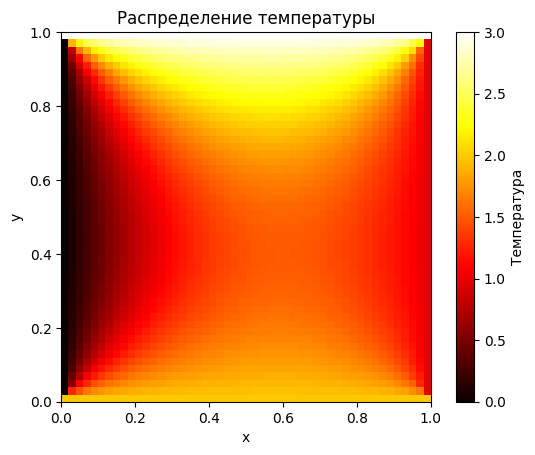

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры сетки
Nx = 50  # Число узлов по x
Ny = 50  # Число узлов по y
hx = 1.0 / (Nx - 1)
hy = 1.0 / (Ny - 1)
tau = 0.5 * min(hx**2, hy**2)  # Условие устойчивости
T = 1  # Конечное время
Nt = int(T / tau)  # Число шагов по времени

# Инициализация сетки
u = np.zeros((Nx, Ny))

# Граничные условия
u[:, 0] = 2  # y = 0
u[:, -1] = 3  # y = 1
u[0, :] = 0  # x = 0
u[-1, :] = 1  # x = 1

# Основной цикл по времени
for n in range(Nt):
    # Промежуточный шаг (по x)
    u_tilde = np.zeros((Nx, Ny))
    for m in range(1, Nx-1):
        for l in range(1, Ny-1):
            u_tilde[m, l] = u[m, l] + (tau / hx**2) * (u[m-1, l] - 2*u[m, l] + u[m+1, l])
    
    # Граничные условия для u_tilde
    u_tilde[0, :] = 0  # x = 0
    u_tilde[-1, :] = 1  # x = 1
    u_tilde[:, 0] = 2   # y = 0
    u_tilde[:, -1] = 3  # y = 1
    
    # Шаг по y
    for m in range(1, Nx-1):
        for l in range(1, Ny-1):
            u[m, l] = u_tilde[m, l] + (tau / hy**2) * (u_tilde[m, l-1] - 2*u_tilde[m, l] + u_tilde[m, l+1])
    
    # Обновляем граничные условия для u
    u[0, :] = 0  # x = 0
    u[-1, :] = 1  # x = 1
    u[:, 0] = 2   # y = 0
    u[:, -1] = 3  # y = 1

# Визуализация через heatmap
plt.imshow(u.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(label='Температура')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Распределение температуры')
plt.show()

## Исследование решений на сходимость по сетке

### <a id="theory"></a> Теоретическая оценка

- Для схемы а) $O(\tau + h^2)$
- Для схемы б) $O(\tau^2 + h^2)$
- Для схемы в) $O(\tau^2 + h^2)$
- Для схемы г) $O(\tau + h^2)$

### <a id="practice"></a> Практическая оценка

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

#############################################################
# Схема а)
def solve_heat_ADI(_Nx=50, _Ny=50, _tau=0.001, _T=1):
    # Параметры сетки
    Nx, Ny = _Nx, _Ny  # Количество узлов по x и y
    hx, hy = 1.0 / (Nx - 1), 1.0 / (Ny - 1)
    tau = _tau  # Шаг по времени
    T = _T  # Общее время
    
    # Инициализация
    u = np.zeros((Nx, Ny))
    
    # Граничные условия
    u[:, 0] = 2  # y = 0
    u[:, -1] = 3  # y = 1
    u[0, :] = 0  # x = 0
    u[-1, :] = 1  # x = 1
    
    # Коэффициенты для разностных операторов
    alpha = tau / hx**2
    beta = tau / hy**2
    
    # Первый полушаг (неявный по x)
    def step_x(u, alpha, Nx, Ny):
        # Строим матрицу для неявной схемы по x
        main_diag = np.ones(Nx - 2) * (1 + 2 * alpha)
        off_diag = np.ones(Nx - 3) * (-alpha)
        A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
        
        # Решаем для каждого y
        for l in range(1, Ny - 1):
            b = u[1:-1, l].copy()
            # Учет граничных условий
            b[0] += alpha * u[0, l]
            b[-1] += alpha * u[-1, l]
            u[1:-1, l] = spsolve(A, b)
        return u
    
    # Второй полушаг (неявный по y)
    def step_y(u, beta, Nx, Ny):
        # Строим матрицу для неявной схемы по y
        main_diag = np.ones(Ny - 2) * (1 + 2 * beta)
        off_diag = np.ones(Ny - 3) * (-beta)
        A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')
        
        # Решаем для каждого x
        for m in range(1, Nx - 1):
            b = u[m, 1:-1].copy()
            # Учет граничных условий
            b[0] += beta * u[m, 0]
            b[-1] += beta * u[m, -1]
            u[m, 1:-1] = spsolve(A, b)
        return u
    
    # Временной цикл
    for n in range(int(T / tau)):
        u = step_x(u, alpha, Nx, Ny)  # Шаг по x
        u = step_y(u, beta, Nx, Ny)   # Шаг по y

    return u

#############################################################
# Схема б)
def solve_heat_KN(_Nx=50, _Ny=50, _tau=0.0001, _T=1):
    # Параметры сетки
    Nx, Ny = _Nx, _Ny
    hx, hy = 1/(Nx-1), 1/(Ny-1)
    tau = _tau
    T = _T
    Nt = int(T/tau)

    # Инициализация с учетом граничных условий
    u = np.zeros((Nx, Ny))
    u[:, 0] = 2.0   # y=0
    u[:, -1] = 3.0  # y=1
    u[0, :] = 0.0   # x=0
    u[-1, :] = 1.0  # x=1

    def step_x(u_prev, hx, hy, tau):
        """Полушаг по x с обновлением только внутренних точек"""
        u_next = u_prev.copy()  # Сохраняем границы

        # Строим матрицу
        alpha = tau/hx**2
        main_diag = (1 + alpha) * np.ones(Nx)
        off_diag = (-alpha/2) * np.ones(Nx-1)
        A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')

        for l in range(1, Ny-1):
            # Правая часть с перекрестными производными
            b = u_prev[:, l].copy()
            b[1:-1] += (tau/(2*hy**2)) * (
                u_prev[1:-1, l+1] - 2*u_prev[1:-1, l] + u_prev[1:-1, l-1]
            )

            # Решаем только для внутренних точек
            u_next[1:-1, l] = spsolve(A, b)[1:-1]

        return u_next

    def step_y(u_prev, hx, hy, tau):
        """Полушаг по y с обновлением только внутренних точек"""
        u_next = u_prev.copy()  # Сохраняем границы

        # Строим матрицу
        beta = tau/hy**2
        main_diag = (1 + beta) * np.ones(Ny)
        off_diag = (-beta/2) * np.ones(Ny-1)
        A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')

        for m in range(1, Nx-1):
            # Правая часть с перекрестными производными
            b = u_prev[m, :].copy()
            b[1:-1] += (tau/(2*hx**2)) * (
                u_prev[m+1, 1:-1] - 2*u_prev[m, 1:-1] + u_prev[m-1, 1:-1]
            )

            # Решаем только для внутренних точек
            u_next[m, 1:-1] = spsolve(A, b)[1:-1]

        return u_next

    # Временной цикл
    for k in range(Nt):
        u = step_x(u, hx, hy, tau)
        u = step_y(u, hx, hy, tau)

    return u

#############################################################
# Схема в)
def solve_heat_step(_Nx=50, _Ny=50, _tau=0.0001, _T=1):
    # Параметры сетки
    Nx, Ny = _Nx, _Ny
    hx, hy = 1/(Nx-1), 1/(Ny-1)
    tau = _tau
    T = _T  # Увеличим время для установления стационарного режима
    Nt = int(T/tau)

    # Инициализация с учетом граничных условий
    u = np.zeros((Nx, Ny))
    u[:, 0] = 2   # y=0
    u[:, -1] = 3  # y=1
    u[0, :] = 0   # x=0
    u[-1, :] = 1  # x=1

    def step_x(u_prev, hx, hy, tau):
        Nx, Ny = u_prev.shape
        u_next = u_prev.copy()  # Сохраняем граничные условия

        main_diag = (1 + tau/hx**2) * np.ones(Nx)
        off_diag = (-tau/(2*hx**2)) * np.ones(Nx-1)
        A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')

        for l in range(1, Ny-1):
            b = u_prev[:, l] + (tau/(2*hy**2))*(u_prev[:, l+1] - 2*u_prev[:, l] + u_prev[:, l-1])
            # Граничные x=0 и x=1 уже учтены в u_prev
            u_next[1:-1, l] = spsolve(A, b)[1:-1]  # Обновляем только внутренние точки

        return u_next

    def step_y(u_prev, hx, hy, tau):
        Nx, Ny = u_prev.shape
        u_next = u_prev.copy()  # Сохраняем граничные условия

        main_diag = (1 + tau/hy**2) * np.ones(Ny)
        off_diag = (-tau/(2*hy**2)) * np.ones(Ny-1)
        A = diags([main_diag, off_diag, off_diag], [0, 1, -1], format='csc')

        for m in range(1, Nx-1):
            b = u_prev[m, :] + (tau/(2*hx**2))*(u_prev[m+1, :] - 2*u_prev[m, :] + u_prev[m-1, :])
            # Граничные y=0 и y=1 уже учтены в u_prev
            u_next[m, 1:-1] = spsolve(A, b)[1:-1]  # Обновляем только внутренние точки

        return u_next

    # Временной цикл
    for k in range(Nt):
        u = step_x(u, hx, hy, tau)
        u = step_y(u, hx, hy, tau)

    return u

#############################################################
# Схема г)
def solve_heat_basic(_Nx=50, _Ny=50, _tau=0.0001, _T=1):
    # Параметры сетки
    Nx = _Nx  # Число узлов по x
    Ny = _Ny  # Число узлов по y
    hx = 1.0 / (Nx - 1)
    hy = 1.0 / (Ny - 1)
    tau = min(_tau, 0.25 * min(hx**2, hy**2))  # Жёсткое условие устойчивости для 2D
    #tau = _tau
    T = _T  # Конечное время
    Nt = int(T / tau)  # Число шагов по времени

    # Инициализация сетки
    u = np.zeros((Nx, Ny))

    # Граничные условия
    u[:, 0] = 2  # y = 0
    u[:, -1] = 3  # y = 1
    u[0, :] = 0  # x = 0
    u[-1, :] = 1  # x = 1

    # Основной цикл по времени
    for n in range(Nt):
        # Промежуточный шаг (по x)
        # u_tilde = np.zeros((Nx, Ny))
        u_new = u.copy()  # Создаем копию для обновления
        for m in range(1, Nx-1):
            for l in range(1, Ny-1):
                u_new[m, l] = u[m, l] + (tau / hx**2) * (u[m-1, l] - 2*u[m, l] + u[m+1, l])\
                                      + (tau / hy**2) * (u[m, l-1] - 2*u[m, l] + u[m, l+1])

        # Граничные условия для u_tilde
        # u_tilde[0, :] = 0  # x = 0
        # u_tilde[-1, :] = 1  # x = 1
        # u_tilde[:, 0] = 2   # y = 0
        # u_tilde[:, -1] = 3  # y = 1

        # Обновляем граничные условия (если нужно)
        u_new[:, 0] = 2  # y = 0
        u_new[:, -1] = 3  # y = 1
        u_new[0, :] = 0  # x = 0
        u_new[-1, :] = 1  # x = 1

        # Шаг по y
        #for m in range(1, Nx-1):
        #    for l in range(1, Ny-1):
        #        u[m, l] = u_tilde[m, l] + (tau / hy**2) * (u_tilde[m, l-1] - 2*u_tilde[m, l] + u_tilde[m, l+1])

        # Обновляем граничные условия для u
        # u[0, :] = 0  # x = 0
        # u[-1, :] = 1  # x = 1
        # u[:, 0] = 2   # y = 0
        # u[:, -1] = 3  # y = 1
        u = u_new

    return u

In [4]:
# Визуализация
def visualize(u):
  '''
  u = solve_heat_...()
  '''
  plt.imshow(u.T, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
  plt.colorbar(label='Температура')
  plt.title('Распределение температуры')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

In [ ]:
raise AttributeError
u_exact = solve_heat_ADI(200, 200, 1e-4)
np.save('exact.npy', u_exact)

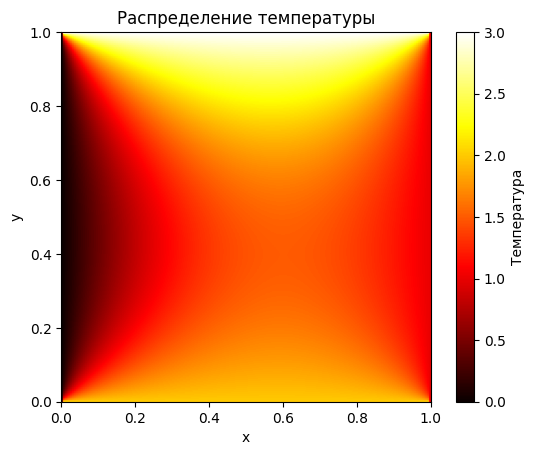

In [6]:
u_exact  = np.load('exact.npy')
visualize(u_exact)

In [75]:
N_ref = 30
u_ref = solve_heat_ADI(N_ref, N_ref, 1e-5)
np.save('ref.npy', u_ref)

In [78]:
import numpy as np
from tqdm.notebook import tqdm

u_ref = np.load('ref.npy')

tau_list = [1e-4, 1e-3, 1e-2]
errors_dic = {
    'ADI': [],
    'KN': [],
    'Step': [],
    'Basic': []
}

for tau in tqdm(tau_list):
    N = N_ref
    h = 1.0 / (N - 1)

    # Численное решение
    u_num_a = solve_heat_ADI(N, N, tau)
    u_num_b = solve_heat_KN(N, N, tau)
    u_num_c = solve_heat_step(N, N, tau)
    u_num_d = solve_heat_basic(N, N, tau)
    
    # Ошибка (пример для аналитического решения)
    error_a = np.max(np.abs(u_num_a - u_ref))  # L∞-норма
    error_b = np.max(np.abs(u_num_b - u_ref))  # L∞-норма
    error_c = np.max(np.abs(u_num_c - u_ref))  # L∞-норма
    error_d = np.max(np.abs(u_num_d - u_ref))  # L∞-норма

    errors_dic['ADI'].append(error_a)
    errors_dic['KN'].append(error_b)
    errors_dic['Step'].append(error_c)
    errors_dic['Basic'].append(error_d)

  0%|          | 0/3 [00:00<?, ?it/s]

ADI: порядок аппроксимации = 1
KN: порядок аппроксимации = 1
Step: порядок аппроксимации = 2
Basic: порядок аппроксимации = -0


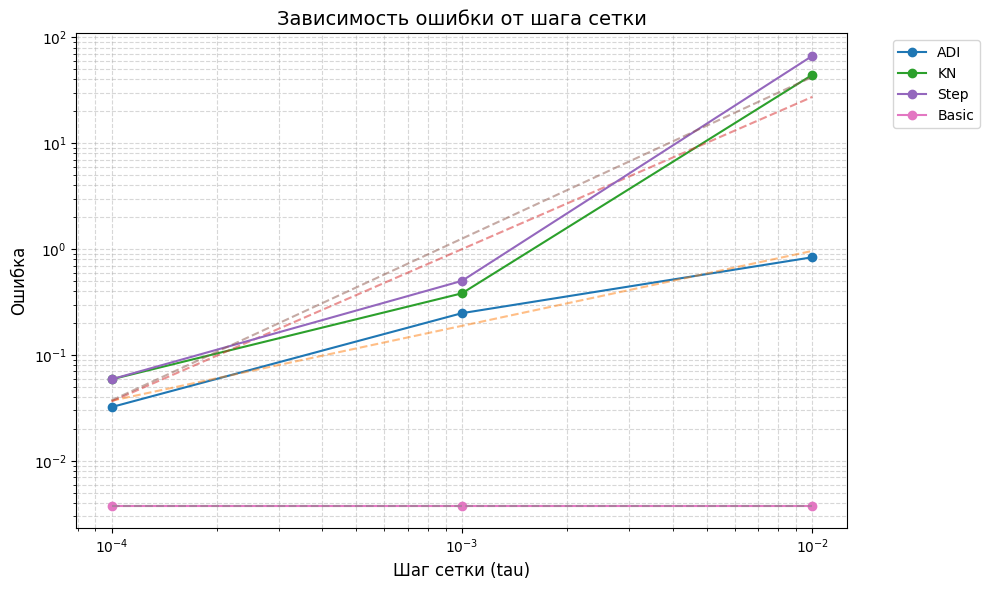

In [79]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Перебираем все методы и их ошибки
for method_name, errors in errors_dic.items():
    # Линейная регрессия в логарифмических координатах
    slope, intercept = np.polyfit(np.log(tau_list), np.log(errors), 1)
    
    # Выводим наклон (порядок аппроксимации)
    print(f'{method_name}: порядок аппроксимации = {slope:.0f}')
    
    # Строим график ошибок
    plt.loglog(tau_list, errors, 'o-', label=f'{method_name}')
    
    # Добавляем линию регрессии
    regression_line = np.exp(intercept) * np.power(tau_list, slope)
    plt.loglog(tau_list, regression_line, '--', alpha=0.5)

plt.xlabel('Шаг сетки (tau)', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.title('Зависимость ошибки от шага сетки', fontsize=14)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# <a id="conclusion"></a> Выводы

В работе были рассмотрены четыре различные схемы решения двумерного уравнения теплопроводности.\
Было проведено сравнение решений, получаемых с их использованием, а также определены порядки аппроксимации по времени (по расчётной сетке). Результаты согласуются с теорией для всех схем, кроме Кранка-Николсона.
Для явной схемы исследование провести не удалось, так как при заданных $\tau$ она расходится, а меньшие $\tau$ приводят к значительному увеличению времени моделирования.